# <center>LaLaNet Recurrent neural network</center>


## Imports

In [144]:
# Classifiers
from keras.models import Sequential, load_model
from keras.layers import LSTM, Conv2D, GRU
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Input, Activation
from keras.datasets import imdb
from sklearn.neighbors import KNeighborsClassifier

# Useful tools
from matplotlib import pyplot as plt
%matplotlib inline
import numpy

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12524658663129302783
, name: "/gpu:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 10211288589872603019
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:01:00.0"
]


## Dataset imports

In [145]:
def append_dataset(X, Y, Yidx, fn, isFirst=False):
    tmpX = numpy.load(fn)
    tmpY = numpy.ones(4)*0
    tmpY[Yidx] = 1
    if isFirst:
        X = tmpX
    else:
        X = numpy.concatenate((X, tmpX))
    for i in range(len(tmpX)):
        Y.append(tmpY.tolist())
    return (X, Y)

corr = {
    0: 'Left and Stay',
    1: 'Left and Back',
    2: 'Right and Stay',
    3: 'Right and Back',
    4: 'No gesture'
}

In [146]:
def import_train_dataset():
    X = []
    Y = []
    X, Y = append_dataset(X, Y, 0, 'train/leftStay.npy', isFirst=True)
    X, Y = append_dataset(X, Y, 0, 'train/leftStay2.npy')
    X, Y = append_dataset(X, Y, 0, 'train/TuetuopayLeftStay.npy')
    X, Y = append_dataset(X, Y, 1, 'train/leftBack.npy')
    X, Y = append_dataset(X, Y, 1, 'train/TuetuopayLeftBack.npy')
    X, Y = append_dataset(X, Y, 2, 'train/rightStay.npy')
    X, Y = append_dataset(X, Y, 2, 'train/rightStay2.npy')
    X, Y = append_dataset(X, Y, 2, 'train/TuetuopayRightStay.npy')
    X, Y = append_dataset(X, Y, 3, 'train/rightBack.npy')
    X, Y = append_dataset(X, Y, 3, 'train/TuetuopayRightBack.npy')
    
    return (X, Y)

X_train, Y_train = import_train_dataset()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

#X_train = X_train[:, :, 0:2]

In [147]:
def import_test_dataset():
    X = []
    Y = []
    X, Y = append_dataset(X, Y, 0, 'test/testLeftStay.npy', isFirst=True)
    X, Y = append_dataset(X, Y, 1, 'test/testLeftBack.npy')
    X, Y = append_dataset(X, Y, 2, 'test/testRightStay.npy')
    X, Y = append_dataset(X, Y, 3, 'test/testRightBack.npy')
    X, Y = append_dataset(X, Y, 2, 'train/mattRightStay.npy')

    return (X, Y)

X_test, Y_test = import_test_dataset()

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
#X_test = X_test[:, :, 0:2]

In [148]:
numpy.shape(Y_train)

(320, 4)

## KNN on full signal

In [149]:
def predict_to_corr(prediction):
    corrs = []
    for i in range(len(prediction)):
        if prediction[i] > 0.5:
            corrs.append(i)
    if len(corrs) > 1:
        print("ERROR: Predicted more than one gesture")
        print("Predicted: " + corrs)
    elif len(corrs) == 0:
        return 4
    else:
        return corrs[0]

In [150]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluation of KNN

ERROR on 10
Predicted No gesture but it was Left and Stay
ERROR on 29
Predicted Left and Stay but it was Left and Back
ERROR on 45
Predicted Right and Stay but it was Right and Back
ERROR on 46
Predicted Right and Stay but it was Right and Back
ERROR on 47
Predicted Right and Stay but it was Right and Back
ERROR on 48
Predicted Right and Stay but it was Right and Back
ERROR on 50
Predicted Right and Stay but it was Right and Back
ERROR on 52
Predicted Right and Stay but it was Right and Back
ERROR on 53
Predicted Right and Stay but it was Right and Back
Evaluation results: 94.375% accuracy


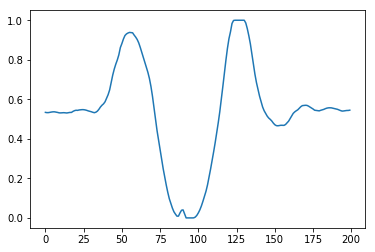

In [151]:
def evaluate_knn(X, Y):
    predictions = knn.predict(X)
    nb_err = 0
    for i in range(len(predictions)):
        if numpy.sum(abs(predictions[i] - Y[i])) > 0.1:
            print("ERROR on " + str(i))
            print("Predicted " + corr[predict_to_corr(predictions[i])] + " but it was " + corr[predict_to_corr(Y[i])])
            nb_err += 1
    print("Evaluation results: " + str(100*(1 - (nb_err/len(predictions)))) + "% accuracy")
    
evaluate_knn(X_test, Y_test)
plt.plot(X_test[29, 0:-1:6])

## KNN on each sample followed by NN

In [6]:
# create the model
model = Sequential([LSTM(48, input_shape=(200,6)), LSTM(98), Dense(4), Activation('sigmoid')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=3, shuffle=True)
# Final evaluation of the model
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Overfit Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

ValueError: Input 0 is incompatible with layer lstm_2: expected ndim=3, found ndim=2

In [108]:
# Final evaluation of the model
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 50.00%


In [109]:
model.save('testLeftRight.h5')

In [110]:
# create the model
#model2 = load_model('testLeftRight.h5')
model.predict(X_test)

array([[-0.20957159,  0.21986596],
       [-0.20942318,  0.21943694],
       [-0.21059142,  0.22073302],
       [-0.20812389,  0.21537575],
       [-0.21261808,  0.22276542],
       [-0.20712902,  0.21739796],
       [-0.20588119,  0.21087363],
       [-0.20669277,  0.21383318],
       [-0.20660695,  0.21496765],
       [-0.21095656,  0.22170407],
       [-0.21089993,  0.22219233],
       [-0.20980132,  0.22342038],
       [-0.21019219,  0.22205734],
       [-0.21240862,  0.22563259],
       [-0.210081  ,  0.2217537 ],
       [-0.21216086,  0.22829664],
       [-0.21358401,  0.23207414],
       [-0.21959601,  0.23677367],
       [-0.21550632,  0.233804  ],
       [-0.2144694 ,  0.23446827],
       [-0.21365508,  0.2324829 ],
       [-0.21617468,  0.23612443],
       [-0.21262904,  0.22747087],
       [-0.21191151,  0.22879048],
       [-0.2119544 ,  0.23143379],
       [-0.21336219,  0.23063831],
       [-0.21420249,  0.23257491],
       [-0.21044502,  0.22676508],
       [-0.21368009,

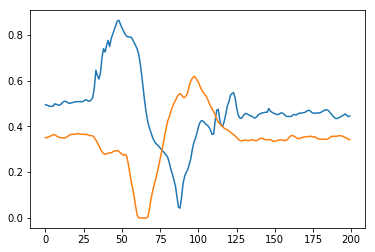

In [92]:
plt.plot(X_train[0].T[0])
plt.plot(X_train[-1].T[0])

In [187]:
left_back_test[0].T[0]

array([  4.83779660e-01,   4.84817273e-01,   4.86633097e-01,
         4.88708324e-01,   4.92233158e-01,   4.93789578e-01,
         4.93102922e-01,   4.91714351e-01,   4.87014572e-01,
         4.81429770e-01,   4.78683146e-01,   4.78881514e-01,
         4.82055390e-01,   4.84756237e-01,   4.86007477e-01,
         4.85595483e-01,   4.85656519e-01,   4.86266880e-01,
         4.85931182e-01,   4.86984054e-01,   4.88998245e-01,
         4.91134508e-01,   4.92080568e-01,   4.90417334e-01,
         4.87685969e-01,   4.85076677e-01,   4.85122454e-01,
         4.87579156e-01,   4.89410239e-01,   4.89913787e-01,
         4.89669642e-01,   4.88418402e-01,   4.85961700e-01,
         4.80346380e-01,   4.76958877e-01,   4.77401389e-01,
         4.81521324e-01,   4.86953536e-01,   4.91042954e-01,
         4.91073472e-01,   4.88830396e-01,   4.87045090e-01,
         4.86358434e-01,   4.85809110e-01,   4.85458152e-01,
         4.87045090e-01,   4.88281071e-01,   4.88494697e-01,
         4.85778592e-01,